In [ ]:
pip install nrclex

In [ ]:
#importing required libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nrclex import NRCLex
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
#downloading nltk.
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

In [86]:
df = pd.read_csv("fordAndCompOnReddit.csv")

In [87]:
#creating all functions
#defining a function to retrieve the sentiment for sentiment analysis.
def getSent(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"
#defining a function to delete stopwords.
stopwords = set(stopwords.words('english'))
def delStopwords(text):
    words = text.split()
    wordsFiltered = [word for word in words if word.lower() not in stopwords]
    return " ".join(wordsFiltered)

In [88]:
#converting 'datetime' column to datetime, creating columns for 'month' and 'year' data and identifying the date range.
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['month'] = df['datetime'].dt.to_period('M')
df['year'] = df['datetime'].dt.year
minDate = df['datetime'].min()
maxDate = df['datetime'].max()
print(f"Dates: {minDate} to {maxDate}")

Dates: 2009-05-24 18:12:07 to 2024-12-07 18:15:58


In [89]:
#removing stopwords
df['woutStopwords'] = df['title'].apply(delStopwords)

In [90]:
lemm = WordNetLemmatizer()
#removing punctuation, converting text to lowercase, tokenizing, lemmatizing, and extracting top emotions
df['woutStopwords'] = df['title'].apply(lambda text: " ".join([word for word in text.split() if word.lower() not in stopwords]))
df['woutStopwords'] = df['woutStopwords'].apply(lambda text: text.lower())
df['woutStopwords'] = df['woutStopwords'].apply(lambda text: re.sub(r'[^\w\s]', '', text))
df['lemmatized'] = df['woutStopwords'].apply(lambda text: [lemm.lemmatize(token) for token in word_tokenize(text)])
df['topEmotions'] = df['woutStopwords'].apply(lambda text: NRCLex(text).top_emotions[0][0] if NRCLex(text).top_emotions else None)
#applying sentiment analysis to the 'woutStopwords' column.
df['sentiment'] = df['woutStopwords'].apply(getSent)
#preprocessing 'lemmatized string'
df['lemmString'] = df['lemmatized'].apply(lambda tokens: " ".join(tokens))
df = df[df['lemmString'].str.strip() != ""]

In [91]:
#updating brand variations and assigning colors.
df.loc[:, 'brand'] = df['brand'].replace({'General Motors': 'GM', 'Chevrolet': 'Chevy'})
colors = {'Ford': '#003366', 'Stellantis': '#A7A9AC', 'GM': '#4CAF50'}

In [92]:
#mapping similar companies to one umbrella for easier analysis.
umbrellaMap = {'Ford': 'Ford', 'Lincoln': 'Ford', 'Chevy': 'GM', 'GM': 'GM', 'Cadillac': 'GM', 'Chrysler': 'Stellantis', 'Dodge': 'Stellantis', 'Fiat': 'Stellantis', 'Jeep': 'Stellantis', 'Ram': 'Stellantis'}
df.loc[:, 'umbrella'] = df['brand'].map(umbrellaMap).fillna('Other')

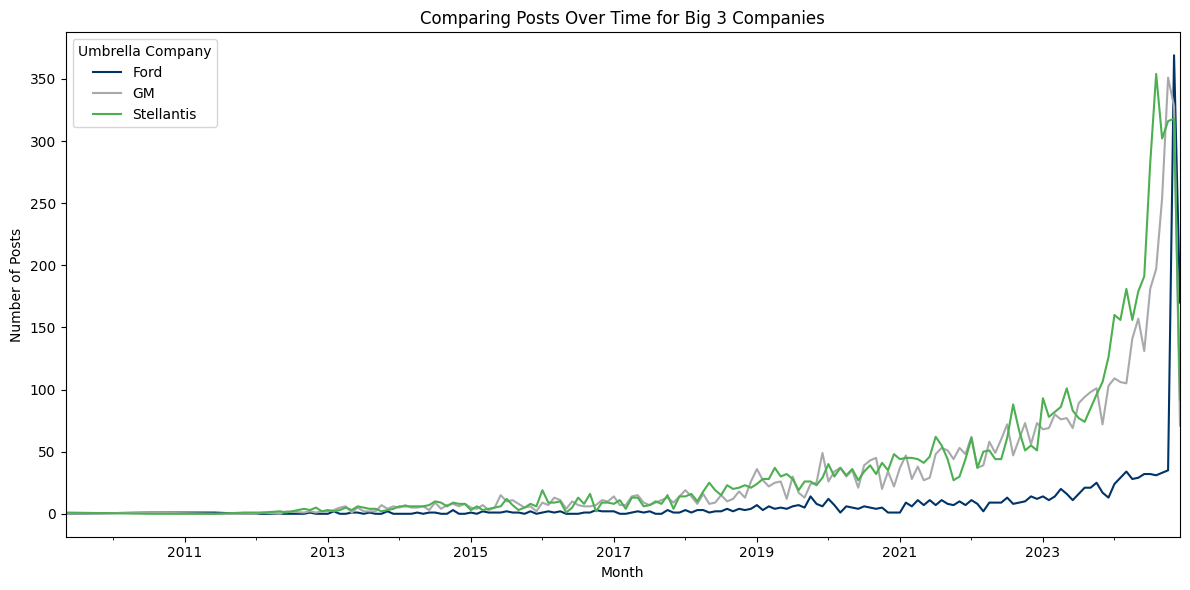

In [93]:
#plotting a visualization of posts over time for each of the Big 3.
postsByMonth = df.groupby(['umbrella', 'month']).size().unstack(level=0, fill_value=0)
postsByMonth.plot(kind='line', figsize=(12, 6), color=['#003366', '#A7A9AC', '#4CAF50'])
plt.title("Comparing Posts Over Time for Big 3 Companies")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.legend(title="Umbrella Company")
plt.tight_layout()
plt.show()

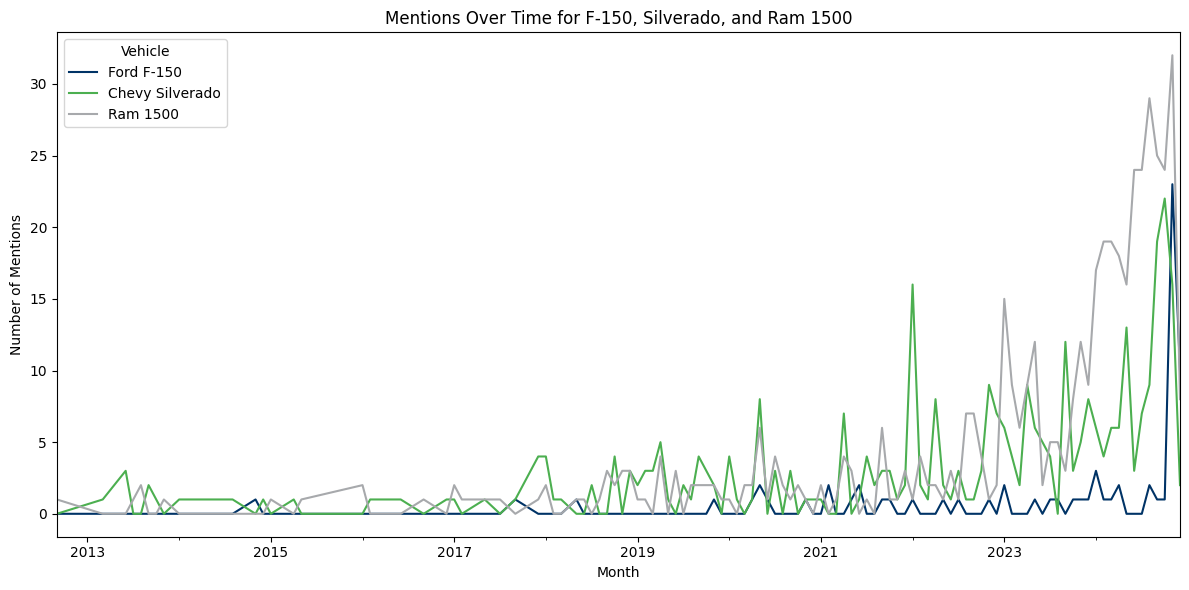

In [94]:
#plotting a line chart of mentions by vehicle: f150, solverado, ram 1500.
mentionsByVehicle = {'Ford F-150': df[df['title'].str.contains('f150', case=False, na=False)].groupby('month').size(),
                     'Chevy Silverado': df[df['title'].str.contains('silverado', case=False, na=False)].groupby('month').size(),
                     'Ram 1500': df[df['title'].str.contains('ram 1500', case=False, na=False)].groupby('month').size()}
vehicleMentionDf = pd.DataFrame(mentionsByVehicle).fillna(0)
vehicleMentionDf.plot(kind='line', figsize=(12, 6), color=['#003366', '#4CAF50', '#A7A9AC'])
plt.title("Mentions Over Time for F-150, Silverado, and Ram 1500")
plt.xlabel("Month")
plt.ylabel("Number of Mentions")
plt.legend(title="Vehicle")
plt.tight_layout()
plt.show()

In [95]:
#calculating percent sentiment by year and filtering for each of the big three for time series analysis.
sentByYear = df.groupby(['umbrella', 'year', 'sentiment']).size().unstack(fill_value=0)
percentByYear = sentByYear.div(sentByYear.sum(axis=1), axis=0) * 100
fordSent = percentByYear.xs('Ford', level='umbrella')
stellantisSent = percentByYear.xs('Stellantis', level='umbrella')
gmSent = percentByYear.xs('GM', level='umbrella')

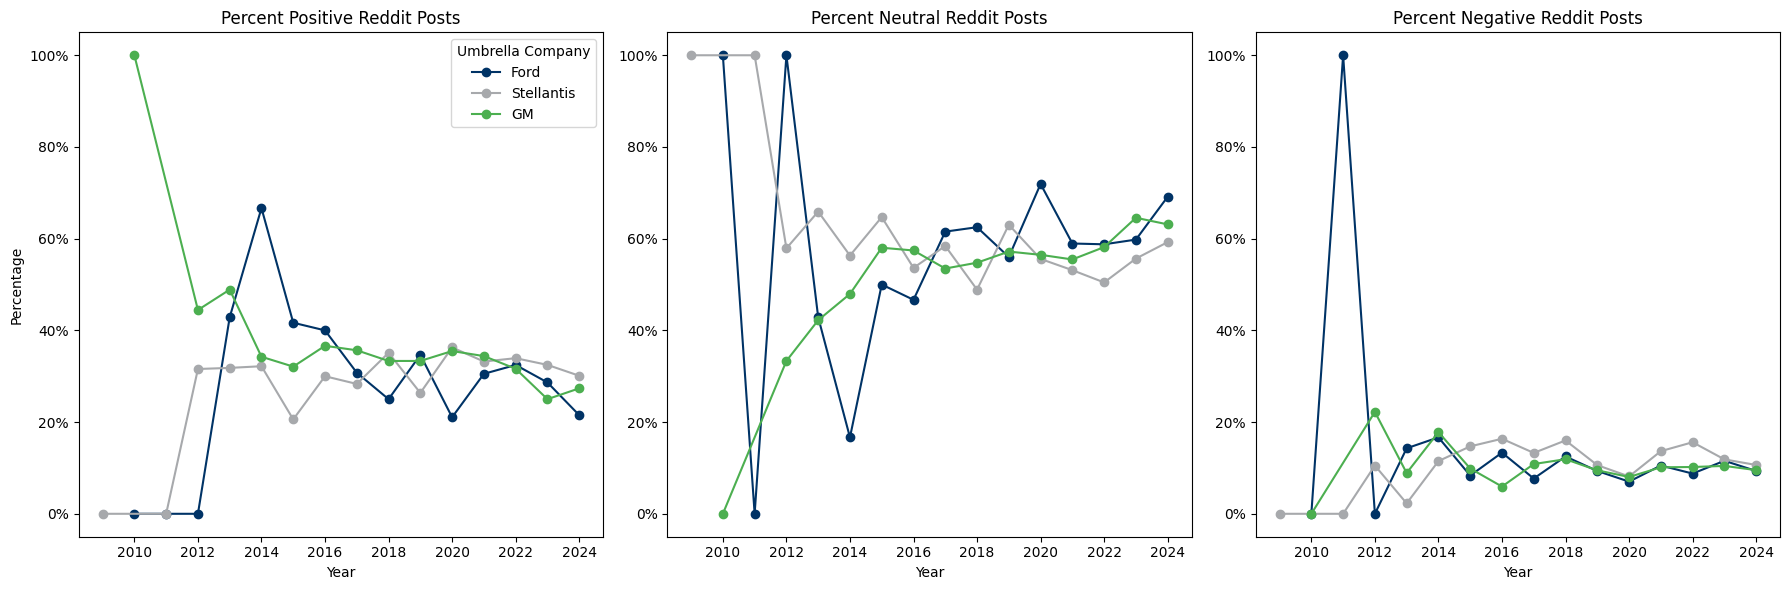

In [96]:
#plotting 3 side by side visualizations for positive, negative and neutral sentiments.
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
#plotting positive yearly sentiment percentages by company
axes[0].plot(fordSent.index, fordSent['Positive'], label='Ford', color=colors['Ford'], marker='o')
axes[0].plot(stellantisSent.index, stellantisSent['Positive'], label='Stellantis', color=colors['Stellantis'], marker='o')
axes[0].plot(gmSent.index, gmSent['Positive'], label='GM', color=colors['GM'], marker='o')
axes[0].set_title("Percent Positive Reddit Posts")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Percentage")
axes[0].yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")
axes[0].legend(title="Umbrella Company")
#plotting neutral yearly sentiment percentages by company
axes[1].plot(fordSent.index, fordSent['Neutral'], label='Ford', color=colors['Ford'], marker='o')
axes[1].plot(stellantisSent.index, stellantisSent['Neutral'], label='Stellantis', color=colors['Stellantis'], marker='o')
axes[1].plot(gmSent.index, gmSent['Neutral'], label='GM', color=colors['GM'], marker='o')
axes[1].set_title("Percent Neutral Reddit Posts")
axes[1].set_xlabel("Year")
axes[1].yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")
#plotting negative yearly sentiment percentages by company
axes[2].plot(fordSent.index, fordSent['Negative'], label='Ford', color=colors['Ford'], marker='o')
axes[2].plot(stellantisSent.index, stellantisSent['Negative'], label='Stellantis', color=colors['Stellantis'], marker='o')
axes[2].plot(gmSent.index, gmSent['Negative'], label='GM', color=colors['GM'], marker='o')
axes[2].set_title("Percent Negative Reddit Posts")
axes[2].set_xlabel("Year")
axes[2].yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")
plt.tight_layout()
plt.show()

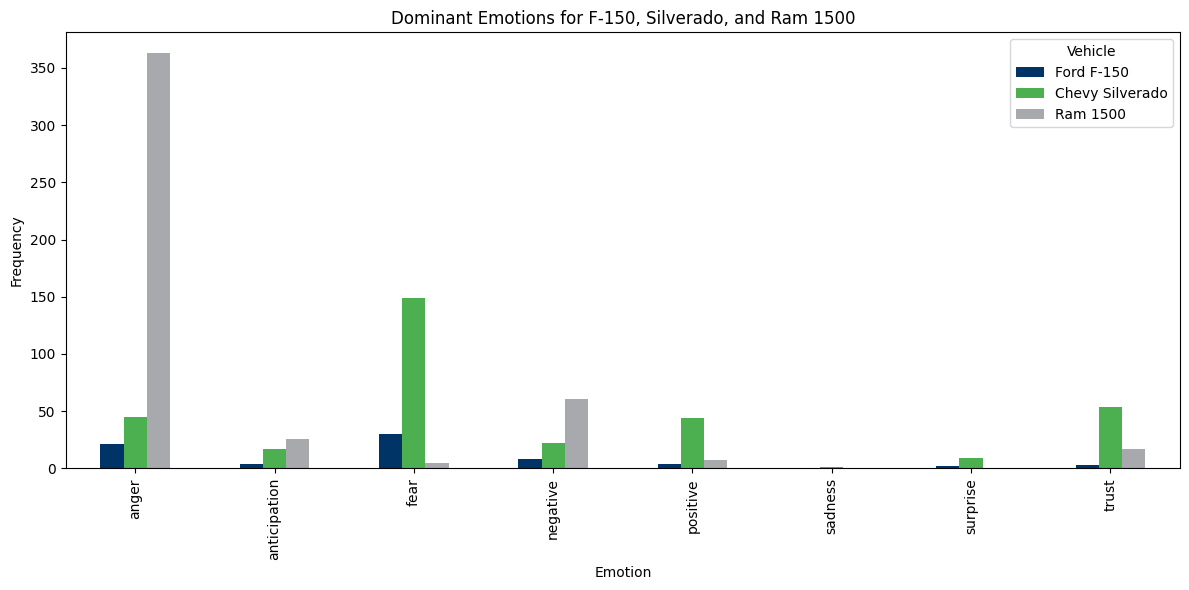

In [97]:
#plotting emotions by pickup truck across each of the Big 3.
vehicles = {'Ford F-150': 'f150', 'Chevy Silverado': 'silverado', 'Ram 1500': 'ram 1500'}
emosByTruck = {vehicle: df[df['title'].str.contains(keyword, case=False, na=False)]['topEmotions'].value_counts()
                  for vehicle, keyword in vehicles.items()}
emosByTruckDf = pd.DataFrame(emosByTruck).fillna(0)
emosByTruckDf.plot(kind='bar', figsize=(12, 6), color=['#003366', '#4CAF50', '#A7A9AC'])
plt.title("Dominant Emotions for F-150, Silverado, and Ram 1500")
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.legend(title="Vehicle")
plt.tight_layout()
plt.show()